# Train 데이터로 X, Y 학습시키기 
- Random seed를 0으로 지정하고 시작

In [77]:
import numpy as np
import pandas as pd 
import time
np.random.seed(0)

In [78]:
# 파라미터 지정 
dimension = 50
alpha = 40
lambda_for_regularization = 40

In [79]:
# Train 데이터 불러오기 

file_path_train = '/Users/yoonminseok/Desktop/DSAIL/2주차/u1.base.csv'
movie_data_train = pd.read_csv(file_path_train, delimiter='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Test 데이터 불러오기 

file_path_test = '/Users/yoonminseok/Desktop/DSAIL/2주차/u1.test.csv'
movie_data_test = pd.read_csv(file_path_test, delimiter='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])


# 타임스탬프 버리기
movie_data_train = movie_data_train[['user_id', 'movie_id', 'rating']]
movie_data_test = movie_data_test[['user_id', 'movie_id', 'rating']]

# R Matrix 만들기 
R_matrix = movie_data_train.pivot(index='user_id', columns='movie_id', values='rating')
R_matrix_test = movie_data_test.pivot(index='user_id', columns='movie_id', values='rating')

In [80]:
def common_columns_matrix(matrix1, matrix2):
    common_columns = set(matrix1.columns) & set(matrix2.columns)

    if not common_columns:
        return None
    common_columns_matrix1 = matrix1[common_columns]
    common_columns_matrix2 = matrix2[common_columns]

    return common_columns_matrix1, common_columns_matrix2

def common_rows_matrix(matrix1, matrix2):
    common_rows = matrix1.index.intersection(matrix2.index)

    if common_rows.empty:
        return None
    common_rows_matrix1 = matrix1.loc[common_rows]
    common_rows_matrix2 = matrix2.loc[common_rows]

    return common_rows_matrix1, common_rows_matrix2

In [81]:
R_matrix, R_matrix_test = common_columns_matrix(R_matrix, R_matrix_test)
R_matrix, R_matrix_test = common_rows_matrix(R_matrix, R_matrix_test)


In [82]:
R_matrix.shape, R_matrix_test.shape 

((459, 1378), (459, 1378))

In [83]:
# 크기 줄이기 
R_matrix = R_matrix.iloc[:450, :1000]
R_matrix_test = R_matrix_test.iloc[:450,:1000]

In [84]:
# M: User , N : Item 
M = R_matrix.shape[0]
N = R_matrix.shape[1]

# Latent matrix 
X = np.random.rand(M, dimension) * 0.01    # 0 ~ 0.01 사이 난수 
Y = np.random.rand(N, dimension) * 0.01

In [85]:
# P_matrix 설정 
P_matrix = np.copy(R_matrix)
P_matrix[P_matrix > 0] = 1
P_matrix = np.nan_to_num(P_matrix, nan=0)

# C_matrix 설정 
# C_matrix = 1 + alpha * R_matrix 도 존재  
C_matrix = 1 + np.log(1+ np.nan_to_num(R_matrix) / 10**(-8))    # 로그 스케일을 쓰는 방법 

In [86]:
def loss_function(C_matrix, P_matrix, xTy, X, Y, lambda_for_regularization):
    # 첫 번째 항 
    predict_error = np.square(P_matrix - xTy)
    confidence_error = np.nansum(C_matrix * predict_error)

    # 두 번째 항 
    regularization =lambda_for_regularization * (np.nansum(np.square(X)) + np.nansum(np.square(Y)))
    total_loss = confidence_error + regularization
    
    return np.nansum(predict_error), confidence_error, regularization, total_loss

In [87]:
# X 업데이트 
# Trick 사용 

def optimize_user(X, Y, C_matrix, P_matrix, M, N, dimension,lambda_for_regularization, yTy):                                                    
    for u in range(M): 
        Cu = np.diag(C_matrix[u])
        yT_Cu_y = yTy + np.matmul(np.matmul(np.transpose(Y), Cu - np.identity(N)), Y)               # 시간복잡도 Trick 사용됨 
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        yT_Cu_pu = np.matmul(np.transpose(Y),P_matrix[u])+ np.matmul(np.matmul(np.transpose(Y), Cu - np.identity(N)), P_matrix[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)                                              # Ax = b에서 x를 구하는 데 사용되는 함수
        
# Y 업데이트 
# Trick 사용 

def optimize_item(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, xTx):                                                          
    for i in range(N):
        Ci = np.diag(C_matrix[:, i])
        xT_Ci_x = xTx + np.matmul(np.matmul(np.transpose(X), Ci - np.identity(M)), X)          
        lI = np.dot(lambda_for_regularization, np.identity(dimension))
        xT_Ci_pi = np.matmul(np.transpose(X),P_matrix[:, i]) + np.matmul(np.matmul(np.transpose(X), Ci-np.identity(M)), P_matrix[:, i])                        
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)                                              # Ax = b에서 x를 구하는 데 사용되는 함수

In [93]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(10):   
    if i!=0:   
        yTy = np.matmul(np.transpose(Y),Y)
        xTx = np.matmul(np.transpose(X),X) 
        start_time = time.time()
        optimize_user(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, yTy)
        optimize_item(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, xTx)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Total execution time: %f seconds" % execution_time)

    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C_matrix, P_matrix, predict, X, Y, lambda_for_regularization)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)

----------------step 0----------------
predict error: 28761.945756
confidence error: 593262.246100
regularization: 96.323088
total loss: 593358.569188
Total execution time: 6.607348 seconds
----------------step 1----------------
predict error: 100035.202147
confidence error: 265997.158344
regularization: 44153.718964
total loss: 310150.877308
Total execution time: 6.075380 seconds
----------------step 2----------------
predict error: 169461.371286
confidence error: 188315.238604
regularization: 73789.363580
total loss: 262104.602183
Total execution time: 6.597061 seconds
----------------step 3----------------
predict error: 89237.071428
confidence error: 113770.607494
regularization: 72921.528555
total loss: 186692.136049
Total execution time: 6.245643 seconds
----------------step 4----------------
predict error: 51121.164756
confidence error: 83277.616396
regularization: 91754.020370
total loss: 175031.636766
Total execution time: 6.034984 seconds
----------------step 5---------------

<Figure size 640x480 with 0 Axes>

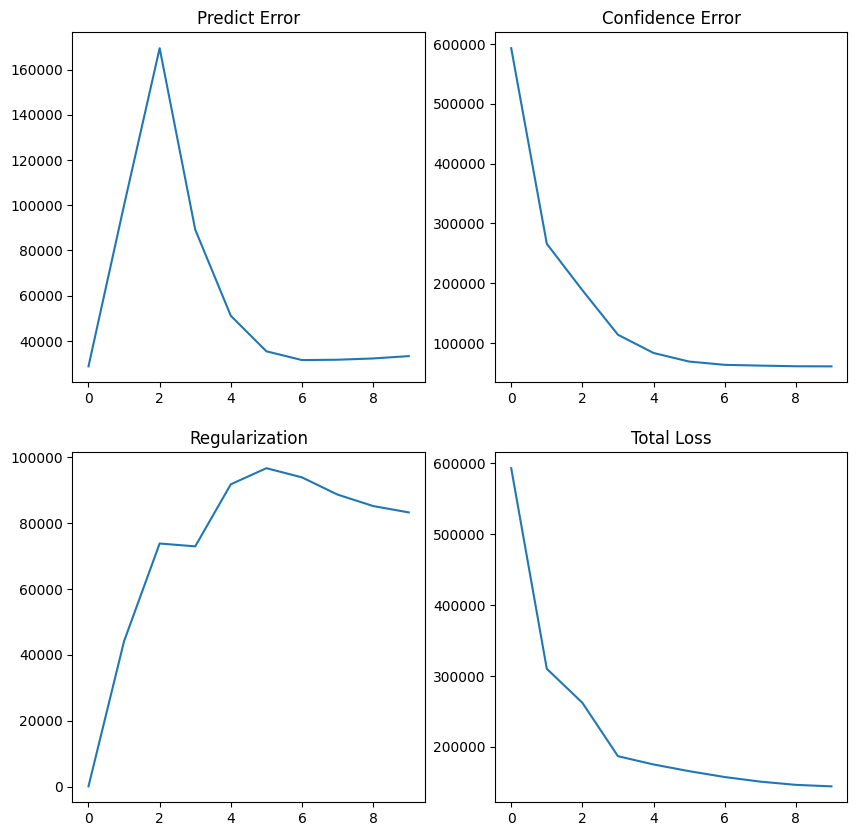

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()

# Explaning of Recommendation

In [71]:
# Pui 값 구하기 
def Predict_P_matrix(Y, C_matrix, R_matrix, user):
    Cu = np.diag(C_matrix[user])
    yT_Cu_y = np.matmul(np.matmul(np.transpose(Y), Cu), Y)   
    lI = np.dot(lambda_for_regularization, np.identity(dimension))
    Weight = np.linalg.inv(yT_Cu_y + lI)
    similarity = np.matmul(np.matmul(Y,Weight),np.transpose(Y))

    C_matrix[R_matrix.isnull()] = 0 
    Predict_P_matrix = np.matmul(similarity, np.transpose(C_matrix[user]))  
    return Predict_P_matrix    

In [100]:
Cu = np.diag(C_matrix[1])
yT_Cu_y = np.matmul(np.matmul(np.transpose(Y), Cu), Y)   
lI = np.dot(lambda_for_regularization, np.identity(dimension))
Weight = np.linalg.inv(yT_Cu_y + lI)
similarity = np.matmul(np.matmul(Y[0],Weight),np.transpose(Y))
Pu = P_matrix[1]
np.matmul(np.matmul(similarity,Cu),Pu)

0.9284351089341775

In [113]:
# 치환한 x 구하기 
test_x = np.matmul(np.matmul(np.matmul(Weight,np.transpose(Y)),Cu),Pu)

In [118]:
original_x = X[1]

In [120]:
original_x - test_x 

array([-0.00968089, -0.00571092, -0.0225884 , -0.00926231,  0.00699132,
       -0.01689658, -0.0040851 ,  0.00540145,  0.0135983 , -0.00613466,
       -0.01843601,  0.00799722, -0.00721995,  0.00402944, -0.0125469 ,
       -0.0144198 , -0.01708122, -0.03105506,  0.01649255, -0.00987189,
       -0.01126397, -0.00540059, -0.01320904, -0.00885514,  0.00497541,
        0.00777793, -0.01413874,  0.01133565, -0.0031673 , -0.01658804,
       -0.005542  , -0.01521021, -0.01900893, -0.00427824,  0.00911837,
       -0.00675734, -0.01032338,  0.00907598, -0.00438013, -0.01418784,
        0.00149899, -0.02373213, -0.00014835, -0.01506464,  0.00161229,
       -0.01521153, -0.01839201, -0.01373542,  0.00191354, -0.02655737])

In [101]:
# User 2의 Item 94 P값 
explain = Predict_P_matrix(Y, C_matrix, R_matrix, 1)
explain[0]

0.9284351089341774

In [103]:
xTy = np.matmul(X,np.transpose(Y))
original = xTy[1][0]
original

0.888192219057905

In [76]:
np.mean(explain - original), max(explain - original)

(0.02254894483959647, 0.028006743288345837)

In [43]:
Cu = np.diag(C_matrix[1])
yT_Cu_y = np.matmul(np.matmul(np.transpose(Y), Cu), Y)   
lI = np.dot(lambda_for_regularization, np.identity(dimension))
Weight = np.linalg.inv(yT_Cu_y + lI)
similarity = np.matmul(np.matmul(Y,Weight),np.transpose(Y))

In [44]:
similarity.shape

(1000, 1000)

## Test 해보기 

In [35]:
# Rank_bar 계산하기 
def rank_list(xTy, user):                    # list는 User i의 predicted P 값을 의미 
    list = xTy[user]
    list_sort = sorted(list)
    rank = [1 - (list_sort.index(i) / (len(list_sort) - 1)) for i in list]
    return rank

def rank_bar(xTy, M, R_matrix_test):
    R_matrix_test = R_matrix_test.fillna(0)
    sum = 0 
    for i in range(M):
        sum += np.matmul(R_matrix_test.iloc[i,:],np.transpose(rank_list(xTy,i))) 
    
    rank_bar = sum / np.nansum(R_matrix_test)
    return rank_bar 

In [61]:
xTy = np.matmul(X, np.transpose(Y))

In [62]:
rank_bar(xTy, M, R_matrix_test)

0.2364803765935235

In [70]:
np.nansum(R_matrix_test)

66639.0

In [69]:
dimension = 10 
X = np.random.rand(M, dimension) * 0.01
Y = np.random.rand(N, dimension) * 0.01

P_matrix = np.copy(R_matrix)
P_matrix[P_matrix > 0] = 1
P_matrix = np.nan_to_num(P_matrix, nan=0)

C_matrix = 1 + np.log(1 + np.nan_to_num(R_matrix) / 10**(-8))

for i in range(10):   
    if i != 0:   
        yTy = np.matmul(np.transpose(Y), Y)
        xTx = np.matmul(np.transpose(X), X) 
        optimize_user(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, yTy)
        optimize_item(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, xTx)

xTy = np.matmul(X, np.transpose(Y))
rank_bar_value = rank_bar(xTy, M, R_matrix_test)

rank_bar_value

0.19526059771261534

In [64]:
dimensions = list(range(10, 101, 10))
rank_bar_values = []

for dimension in dimensions:
    X = np.random.rand(M, dimension) * 0.01
    Y = np.random.rand(N, dimension) * 0.01

    P_matrix = np.copy(R_matrix)
    P_matrix[P_matrix > 0] = 1
    P_matrix = np.nan_to_num(P_matrix, nan=0)

    C_matrix = 1 + np.log(1 + np.nan_to_num(R_matrix) / 10**(-8))

    for i in range(10):   
        if i != 0:   
            yTy = np.matmul(np.transpose(Y), Y)
            xTx = np.matmul(np.transpose(X), X) 
            optimize_user(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, yTy)
            optimize_item(X, Y, C_matrix, P_matrix, M, N, dimension, lambda_for_regularization, xTx)

    xTy = np.matmul(X, np.transpose(Y))
    rank_bar_value = rank_bar(xTy, M, R_matrix_test)
    rank_bar_values.append(rank_bar_value)

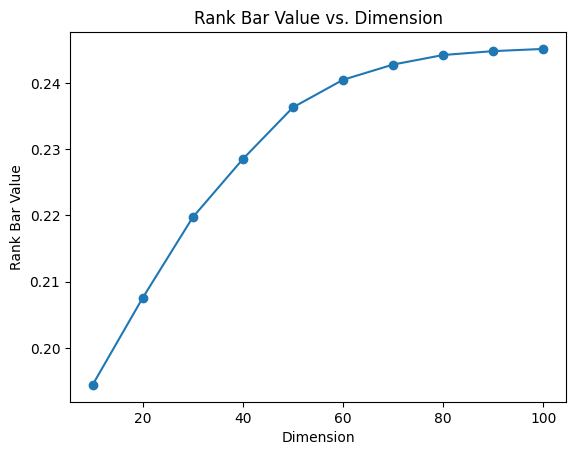

In [66]:
plt.plot(dimensions, rank_bar_values, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Rank Bar Value')
plt.title('Rank Bar Value vs. Dimension')
plt.show()

In [68]:
rank_bar_values

[0.19439966985698479,
 0.20753949225264837,
 0.21971582170564755,
 0.2285090955389129,
 0.23631559349382253,
 0.2404821274102025,
 0.24278248145653117,
 0.24422316943213085,
 0.24481015477278903,
 0.2451404269708866]

In [121]:
pip freeze

anyio==3.7.1
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
attrs==23.2.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
certifi @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_477u68wvzm/croot/certifi_1671487773341/work/certifi
cffi==1.15.1
comm==0.1.4
cycler==0.11.0
debugpy==1.7.0
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
exceptiongroup==1.2.0
fastjsonschema==2.19.1
fonttools==4.38.0
gensim==4.2.0
idna==3.6
importlib-metadata==6.7.0
importlib-resources==5.12.0
ipykernel==6.16.2
ipython==7.34.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
jedi==0.19.1
Jinja2==3.1.2
jsonschema==4.17.3
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-server==1.24.0
jupyter_client==7.4.9
jupyter_core==4.12.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.9
kiwisolver==1.4.5
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
mistune==3.0.2
nbclassic==1.0.0
nbclient==0.7.4
nbconvert==7.6.0
nbformat==5.8.0
nest-asyncio==1.5.8
networkx==2.6.3
not